### **Import packages**

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
import tensorflow as tf

In [4]:
print(os.listdir('.'))

['.ipynb_checkpoints', 'Detect_Face_Mask_Image.ipynb', 'Detect_Face_Mask_Video.ipynb', 'face_detector', 'mask_detector.model', 'MobileNetV2-Model', 'MobileNetv2-Weights', 'MobileNetv2_Face_mask_image_classification.h5', 'Result', 'test_image']


### **Display input image**

In [5]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [6]:
input_image_path = './test_image/example_09.jpg'

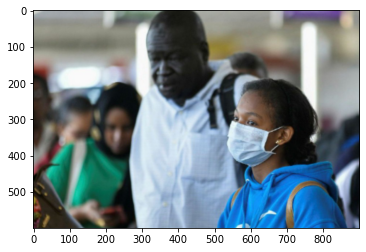

In [7]:
img = plt.imread(input_image_path)
plt.imshow(img)
plt.show()

In [8]:
for i in os.listdir('./face_detector'):
    print(i)

deploy.prototxt
res10_300x300_ssd_iter_140000.caffemodel


### **Dataloaders**

In [9]:
print("[INFO] loading face detector model...")

prototxtPath = './face_detector/deploy.prototxt'
weightsPath = './face_detector/res10_300x300_ssd_iter_140000.caffemodel'

[INFO] loading face detector model...


In [10]:

# prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
# weightsPath = os.path.sep.join([args["face"],
# 	"res10_300x300_ssd_iter_140000.caffemodel"])

net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [11]:
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model('MobileNetv2_Face_mask_image_classification.h5')

[INFO] loading face mask detector model...


In [12]:
# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread(input_image_path)
orig = image.copy()
(h, w) = image.shape[:2]
print(h,w)

600 900


In [13]:
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (150, 150),
	(104.0, 177.0, 123.0))

In [14]:
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


In [15]:
print(detections.shape)

(1, 1, 200, 7)


In [16]:
thresh_confidence = 0.2

### Extract faceROIs

In [17]:
# loop over the detections
for i in range(0, detections.shape[2]):
    confidence = detections[0,0,i,2]
    if confidence > thresh_confidence:
        box = detections[0, 0, i, 3:7]*np.array([w,h,w,h])
        startX,startY,endX,endY = box.astype("int")
        
        (startX,startY) = (max(0,startX),max(0,startY))
        (endX,endY) = (min(w-1,endX), min(h-1,endY))
        
        print(startX,startY,endX,endY)
        
        face = image[startY:endY,startX:endX]
        
        face = cv2.cvtColor(face , cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (128,128))
        
        face = img_to_array(face)
        face = preprocess_input(face)
        
        face = np.expand_dims(face , axis=0)
        
        (mask,withoutMask) = model.predict(face)[0]
        
        label = "Mask" if mask > withoutMask else "withoutMask"
        
        color = (0,255,0) if label == "Mask" else (0,0,255)
        
        label = "{} : {:.2f}".format(label , max(mask,withoutMask)*100)
        
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        
cv2.imshow('output',image)
cv2.waitKey(0)        

306 52 453 241
181 257 286 419
536 230 676 425


27